linearModel = True
logLoss = True


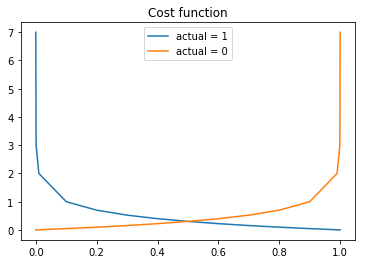

In [155]:
import math
import matplotlib.pyplot as plt


def linearModel(inputs, weights):
    return sum([i[0] * i[1] for i in zip(inputs, weights[1:])]) + weights[0]

def logLoss(target, prediction, epsilon=0.0000001):
    prediction = max(epsilon, min(1 - epsilon, prediction))
    return -target * math.log10(prediction) - (1 - target) * math.log10(1 - prediction)


# unit tests
print(f'linearModel = {linearModel([2, 4], [3, 5, 7]) == 41}')
print(f'logLoss = {math.isclose(round(logLoss(0.63, 0.6), 3), 0.287)}')


# plot the log loss
predictions = [ 0.0, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99, 0.999, 1.0]
targets = [logLoss(1, p) for p in predictions]
plt.plot(predictions, targets, label='actual = 1')

targets = [logLoss(0, p) for p in predictions]
plt.plot(predictions, targets, label='actual = 0')

plt.title('Cost function')
plt.legend()
plt.show()

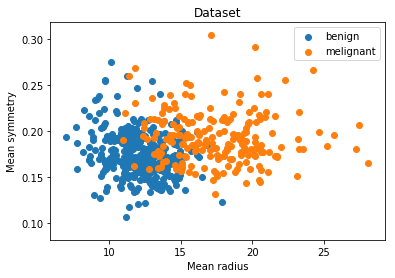

In [189]:
# generate dataset

import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

# <-- Extract subset -->
breastCancerDataSet = load_breast_cancer()

meanRadius = breastCancerDataSet.data[:,0]
meanSymmetry = breastCancerDataSet.data[:,8]

dataSet = list(zip(meanRadius, meanSymmetry))
# </- Extract subset -->

# <-- Plot the dataset -->
def plotDataset(plot, samples, targets):
    benign_X, benign_y, melignant_X, melignant_y = [], [], [], []
    for index in range(len(samples)):
        target = targets[index]
        plot_X, plot_y = (melignant_X, melignant_y) if target == 0 else (benign_X, benign_y)

        sample = samples[index]
        plot_X.append(sample[0])
        plot_y.append(sample[1])

    plot.scatter(benign_X, benign_y, label='benign')
    plot.scatter(melignant_X, melignant_y, label='melignant')
    plot.title('Dataset')
    plot.xlabel('Mean radius')
    plot.ylabel('Mean symmetry')
    plot.legend()

plotDataset(plt, dataSet, breastCancerDataSet.target)
# </- Plot the dataset -->

# split the dataset
X_train, X_test, y_train, y_test = train_test_split(dataSet, breastCancerDataSet.target, test_size=0.2)

In [157]:
# linear classifier

import math


def sigmoid(z):
    return 1 / (1 + math.exp(-z))

def logisticRegressionPredictor(samples, weights):
    return [sigmoid(linearModel(sample, weights)) for sample in samples]

def calcCost(targets, predictions, loss):
    return sum([loss(*i) for i in zip(targets, predictions)]) / len(targets)

def calcGradient(samples, targets, predictions):
    errors = [prediction - target for prediction, target in zip(predictions, targets)]
    updatedSamples = [[error] + [feature * error for feature in sample] for sample, error in zip(samples, errors)]
    gradient = [sum([sample[i] for sample in updatedSamples]) for i in range(len(updatedSamples[0]))]
    return gradient

def gradientDescent(samples, targets, weights, predictions, learningRate):
    gradient = calcGradient(samples, targets, predictions)
    weightsUpdates = [(learningRate / len(samples)) * g for g in gradient]
    return [weight - weightUpdate for weight, weightUpdate in zip(weights, weightsUpdates)]


def runClassifier(samples, targets, weights, predict, loss, minimize, learningRate):
    predictions = predict(samples, weights)
    cost = calcCost(targets, predictions, loss)
    newWeights = minimize(samples, targets, weights, predictions, learningRate)
    
    return cost, newWeights
    
def linearClassifier(predict, loss, minimize, learningRate):
    return lambda samples, targets, weights: runClassifier(samples, targets, weights, predict, loss, minimize, learningRate)


# unit tests
print(f'sigmoid = {round(sigmoid(100)) == 1 and round(sigmoid(-100)) == 0 and sigmoid(0) == 0.5}')
lrPredictorResult = list(map(lambda i: round(i, 2), logisticRegressionPredictor([[2, 4], [12, 14]], [.1, .4])))
print(f'logisticRegressionPredictor = {lrPredictorResult == [0.71, 0.99]}')
print(f'calcCost = {round(calcCost([0, 1], [0.71, 0.99], logLoss), 2) == 0.27}')

sigmoid = True
logisticRegressionPredictor = True
calcCost = True


initial weights = [-0.9458513234245476, 1.2439653806967403, 1.7831553624826963]
final weights = [-0.9494776544858841, 1.180010151290891, 1.7824561219167185]
Custom model:
	Accuracy = 0.5877192982456141
	Average precision-recall score: 0.5877192982456141
	F1: 0.7403314917127072
sci-kit:
	Accuracy = 0.8508771929824561
	Average precision-recall score: 0.7976190476190477
	F1: 0.8874172185430463


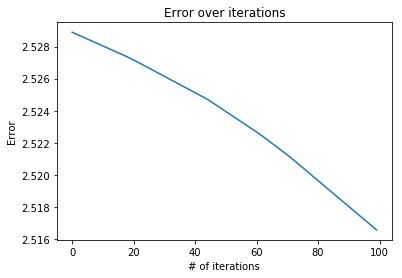

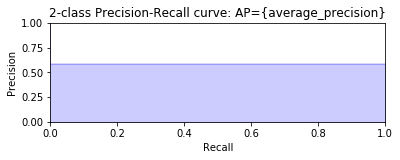

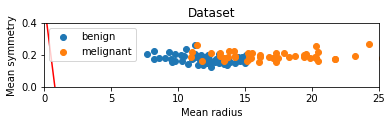

In [250]:
# classify

import random
import matplotlib.pyplot as plt


from sklearn.utils.fixes import signature
from sklearn.metrics import accuracy_score, average_precision_score, precision_recall_curve, f1_score

# <-- learn the parameters -->
weights = [random.normalvariate(0, 1) for _ in range(len(X_train[0]) + 1)]
print(f'initial weights = {weights}')
learningRate = 0.0001
logisticRegression = linearClassifier(logisticRegressionPredictor, logLoss, gradientDescent, learningRate)

iterations = list(range(100))
errorOverIterations = []
for numberOfIteration in iterations:
    error, weights = logisticRegression(X_train, y_train, weights)
    errorOverIterations.append(error)

print(f'final weights = {weights}')
# </- learn the parameters -->


# classify test set
threshold = 0.8
classProbablilties = logisticRegressionPredictor(X_test, weights)
y_prediction = [int(classProbability > threshold) for classProbability in classProbablilties]

# run some metrics
print('Custom model:')
print(f'\tAccuracy = {accuracy_score(y_test, y_prediction)}')
average_precision = average_precision_score(y_test, y_prediction)
print(f'\tAverage precision-recall score: {average_precision}')
print(f'\tF1: {f1_score(y_test, y_prediction)}')

# compare with sci-kit
from sklearn.linear_model import LogisticRegression

logisticRegression = LogisticRegression()
logisticRegression.fit(X_train, y_train)
y_prediction_sk = logisticRegression.predict(X_test)

print('sci-kit:')
print(f'\tAccuracy = {accuracy_score(y_test, y_prediction_sk)}')
average_precision = average_precision_score(y_test, y_prediction_sk)
print(f'\tAverage precision-recall score: {average_precision}')
print(f'\tF1: {f1_score(y_test, y_prediction_sk)}')


# plot error over iterations
plt.plot(iterations, errorOverIterations)
plt.title('Error over iterations')
plt.xlabel('# of iterations')
plt.ylabel('Error')
plt.show()

# plot PR
precision, recall, _ = precision_recall_curve(y_test, y_prediction)
plt.subplot(2, 1, 1)
# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={average_precision}')
plt.show()

# plot decision boundary
def decisionBoundary(x, weights):
    return -(weights[0] + weights[1] * x) / weights[2]
plt.subplot(3, 1, 1)
plotDataset(plt, X_test, y_test)
x_decisionBoundary = range(int(plt.xlim()[1]))
y_decisionBoundary = [decisionBoundary(x, weights) for x in x_decisionBoundary]
plt.plot(x_decisionBoundary, y_decisionBoundary, 'r')
plt.axis([0, 25, 0, 0.4])
plt.show()